In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

In [35]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Text(0, 0.5, 'Predictor Variable(Kelvin)')

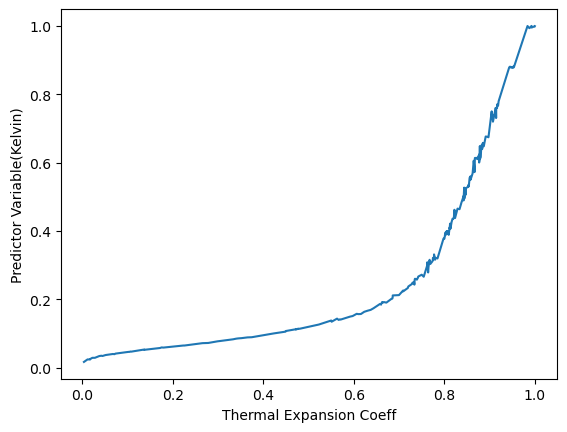

In [36]:
#TODO 1
# Convert x0 and y0 columns from dataframe to numpy arrays
x0 = np.array(df['x0'])
y0 = np.array(df['y0'])

# Scale x0 and y0 to be between 0 and 1 by dividing by their respective maximum values
x = y0 / np.max(y0)
y = x0 / np.max(x0)

# Sort the data based on the values in x
args = np.argsort(x)
x = x[args]
y = y[args]

# Plot the scaled data
plt.plot(x, y)
plt.xlabel('Thermal Expansion Coeff')
plt.ylabel('Predictor Variable(Kelvin)')

Text(0, 0.5, 'Predictor Var(Kelvin)')

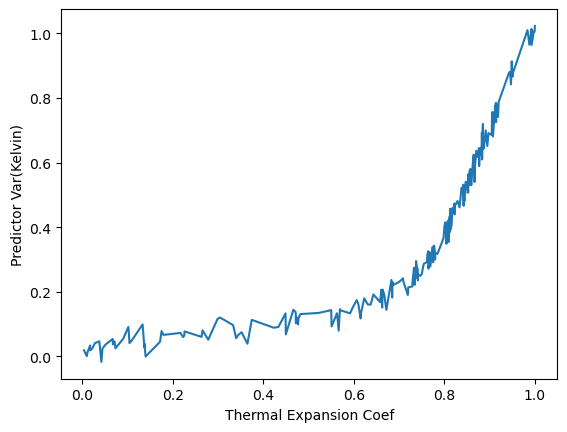

In [37]:
#TODO 2
# Add random Gaussian noise with mean 0 and standard deviation 0.02 to the y values
yn = y + np.random.normal(0, 0.02, y.shape)

# Plot the data with added noise
plt.plot(x, yn)
plt.xlabel('Thermal Expansion Coef')
plt.ylabel('Predictor Var(Kelvin)')

In [38]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
xtr, xts, ytr, yts = train_test_split(x, yn, test_size=0.33, shuffle=True)

# Sort the training data based on the values in xtr
args = np.argsort(xtr)
xtr = xtr[args]
ytr = ytr[args]

# Sort the test data based on the values in xts
args_t = np.argsort(xts)
xts = xts[args_t]
yts = yts[args_t]

In [39]:
def predict(w, x):
    
    d = (len(w) - 1) // 2

    # TODO4
    
    # Extract a and b from w
    a = w[:d + 1]
    b = w[d + 1:]
    
    # Flip the order of a and b because np.polyval
    a = np.flip(a)
    
    # Append 1 to the end of b
    b = np.append(np.flip(b), 1)
    
    # TODO 5
    
    # Compute yhat using the rational model equation
    yhat = np.polyval(a, x) / np.polyval(b, x)
    
    return yhat

In [40]:
#TODO 6,7,8

d = 3

dp = np.arange(1, d + 1)

# Initialize a matrix Z with zeros. 
Z = np.zeros((len(xtr), 2 * d))

# Populate the matrix Z
for i in range(len(xtr)):
    Z[i, :] = np.concatenate((np.power(xtr[i], dp), ytr[i] * np.power(xtr[i], dp)))

# Initialize a linear regression model
regr = LinearRegression()

# Fit the linear regression model to the data in Z and the target values in ytr
regr.fit(Z, ytr)

# Extract the coefficients
a = np.append([regr.intercept_], regr.coef_[0:d])
b = -regr.coef_[d:]

# Concatenate the coefficients of the numerator and denominator polynomials
winit = np.append(a, b)

(0.0, 1.0)

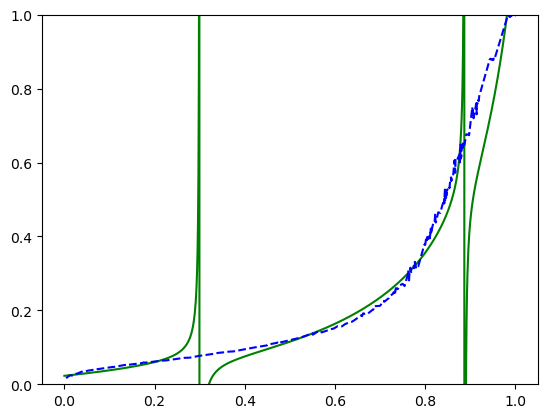

In [41]:
#TODO 9

xp = np.linspace(0,1,1000)
yhat = predict(winit,xp)
plt.plot(xp,yhat,'g',x,y,'b--')
plt.ylim([0,1])

(0.0, 1.0)

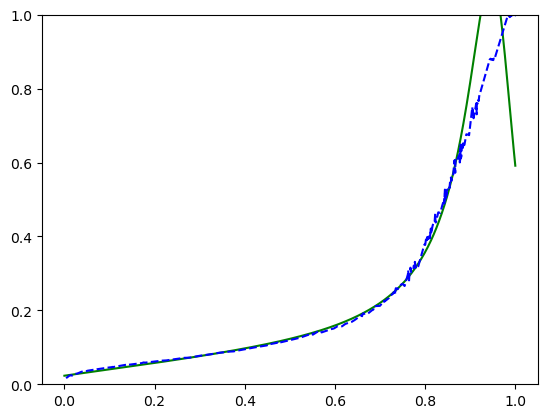

In [42]:
#TODO 10,11,12

# Create a ridge regression model with a regularization parameter of 1e-3
rigregr = Ridge(alpha=1e-3)

# Fit the ridge regression model
rigregr.fit(Z, ytr)

# Extract the coefficients
a = np.concatenate(([rigregr.intercept_], rigregr.coef_[0:d]))
b = -rigregr.coef_[d:]

# Combine the coefficients into a single array
winit = np.append(a, b)

xp = np.linspace(0, 1, 1000)

yhat = predict(winit, xp)

# Plot the predicted values (yhat)
plt.plot(xp, yhat, 'g', x, y, 'b--')

# Set the limits for the y-axis from 0 to 1
plt.ylim(0, 1.0)

In [43]:
#TODO 13,14,15,16,17,18

def feval(w, x, y):
    d = (len(w)-1)//2
    
    a = w[0:d+1]
    b = w[d+1:]
    
    # Initialize matrices
    Znum = np.zeros((len(x), d+1))
    Zden = np.zeros((len(x), d))
    
    # Calculate the values for the num
    for j in range(d+1):
        Znum[:,j] = x[:]**j
        
    # Calculate the values for the den
    for j in range(d):
        Zden[:,j] = x[:]**(j+1)
    
    yhat = np.zeros(len(x))
    
    # Calculate the predicted values
    for i in range(len(x)):
        yhat[i] = Znum[i,:].dot(a)/(1+Zden[i,:].dot(b))
    
    f = 0.5*np.sum(np.square(y-yhat))
    
    # Initialize the gradients
    grada = np.zeros(len(a))
    gradb = np.zeros(len(b))
    
    # Calculate the gradient for the num
    for j in range(len(a)):
        grada[j] = -np.sum((y-yhat)*Znum[:,j]/(1+np.matmul(Zden,b)))
        
    # Calculate the gradient
    for j in range(len(b)):
        gradb[j] = np.sum((y-yhat)*yhat*Zden[:,j]/(1+np.matmul(Zden,b)))
        
    # Combine the gradients
    fgrad = np.concatenate((grada, gradb))
    
    return f, fgrad

In [44]:
#TODO19

w0 = winit
f0, fgrad0 = feval(w0,xtr,ytr)
r1 = 1e-6
wl = w0 + r1
fl,fgradl = feval(wl,xtr,ytr)
print("Actual fl-f0 = %12.4e" % (fl-f0))
print("Predicted fl-f0 = %12.4e" % (fgrad0.dot(wl-w0)))

Actual fl-f0 =   1.6635e-05
Predicted fl-f0 =   1.6150e-05


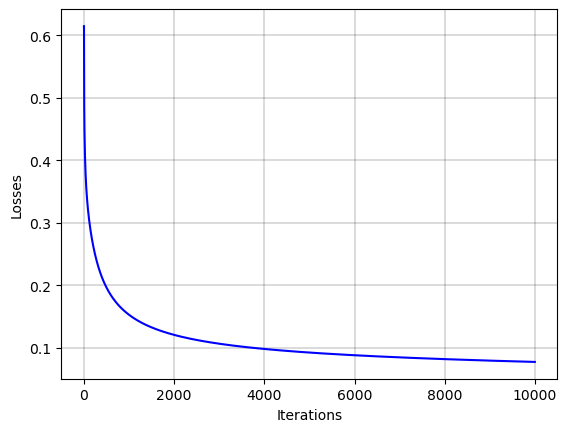

In [45]:
#TODO 20

# Number of iterations for optimization
nit = 10000

# Step size for gradient descent
step = 1e-6

# Initialize history dictionary
hist = { 'w': [], 'f': []}

# Optimization loop
for i in range(nit):
    # Evaluate function value and gradient at current weight vector
    f0, fgrad0 = feval(w0, xtr, ytr)
    
    # Update weight vector using gradient descent
    w0 = w0 - fgrad0 * step
    
    # Store weight vector and function value in history
    hist['w'].append(w0)
    hist['f'].append(f0)

# Convert list of loss values to NumPy array for plotting
loss = np.array(hist['f'])

# Plot loss values against iterations
plt.plot(loss, 'b-')
plt.xlabel('Iterations')
plt.ylabel('Losses')
plt.grid(color='k', linewidth=0.2)


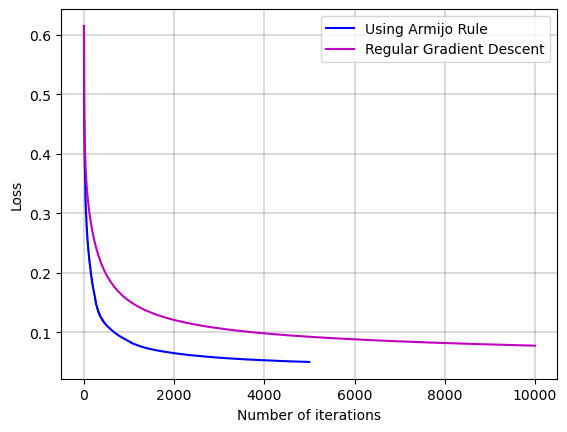

In [46]:
#TODO 21

nit = 10000

# Initial step size for gradient descent
step = 1e-6

# Initialize history dictionary to store weight vectors and function values
hist = {'w':[], 'f':[]}

# Initial weight vector
w0 = winit

# Evaluate function value and gradient at initial weight vector
f0, fgrad0 = feval(winit, xtr, ytr)

# Optimization loop
for i in range(nit):
    # Compute updated weight vector
    w1 = w0 - fgrad0 * step
    
    # Evaluate function value and gradient at updated weight vector
    f1, fgrad1 = feval(w1, xtr, ytr)
    
    # Compute change in function value
    df = fgrad0.dot(w1 - w0)
    
    # Set Armijo rule parameter
    al = 0.5
    
    if (f1 - f0 < al * df) and (f1 < f0):
        # Increase step size if condition is satisfied
        step = step * 2
        
        # Update function value, gradient, and weight vector
        f0 = f1
        fgrad0 = fgrad1
        w0 = w1
    else:
        # Decrease step size if condition is not satisfied
        step = step / 2
        
        # Store weight vector and function value in history dictionary
        hist['w'].append(w0)
        hist['f'].append(f0)

# Convert list of loss values to NumPy array for plotting
loss_arm = np.array(hist['f'])

# Plot loss values for Armijo rule optimization and regular gradient descent
plt.plot(loss_arm, 'b-')
plt.plot(loss, 'm-')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.grid(color='k', linewidth=0.2)
plt.gca().legend(('Using Armijo Rule', 'Regular Gradient Descent'))

(0.0, 1.0)

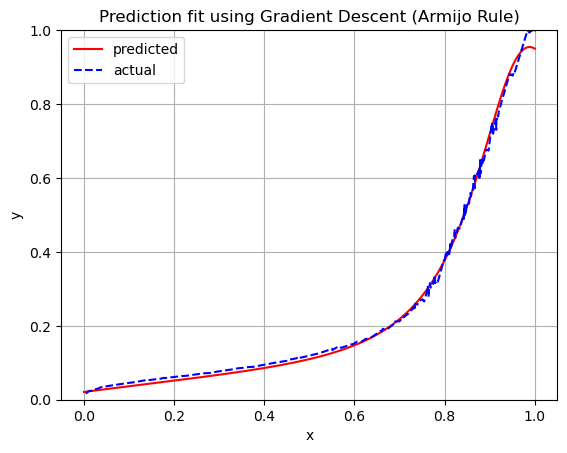

In [47]:
#TODO 22

# Get the final weight vector from the optimization history
w_adapt_fin = np.array(hist['w'])[-2, :]

# Create an array of 1000
xp = np.linspace(0, 1, num=1000)

# Predict the output values for the test input values
yhat = predict(w_adapt_fin, xp)

# Plot the predicted output values and the actual output values
plt.plot(xp, yhat, 'r')
plt.plot(x, y, 'b--')
plt.xlabel('x')
plt.ylabel('y')

plt.legend(('predicted', 'actual'))

# Add title to the plot
plt.title('Prediction fit using Gradient Descent (Armijo Rule)')

# Add grid
plt.grid()

# Set the limits
plt.ylim(0, 1)

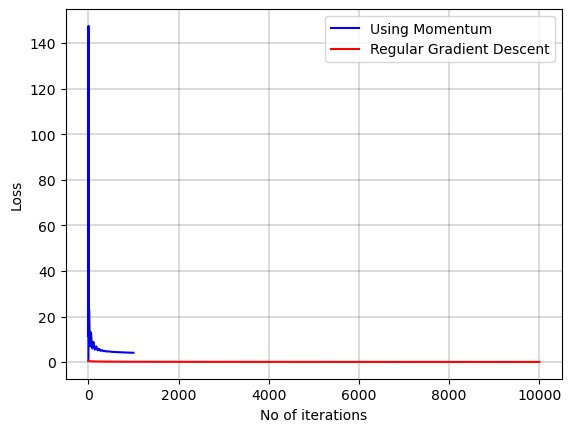

In [48]:
#TODO 23

# Set the number of iterations and the step size for the gradient descent algorithm
nit = 1000
step = 1e-3

# Beta parameter
beta = 0.99

# Initialize a vector z for the momentum term with zeros
z = np.zeros(np.shape(winit))

hist = {'w':[], 'f':[]}

# Initialize weights with initial values
w0 = winit

# Gradient descent with momentum
for i in range(nit):
    # Evaluate the function and its gradient
    f0, fgrad0 = feval(w0, xtr, ytr)
    
    # Update the momentum term
    z = z * beta + fgrad0
    
    # Update weights using the momentum term
    w0 = w0 - z * step
    
    # Store the weights and the loss value for this iteration
    hist['w'].append(w0)
    hist['f'].append(f0)

# Extract the loss values from the history
loss_mom = np.array(hist['f'])

# Plot the loss values for gradient descent with momentum and regular gradient descent
plt.plot(loss_mom, 'b-')
plt.plot(loss, 'r-')
plt.xlabel('No of iterations')
plt.ylabel('Loss')
plt.grid(color='k', linewidth=0.2)
plt.gca().legend(('Using Momentum', 'Regular Gradient Descent'))

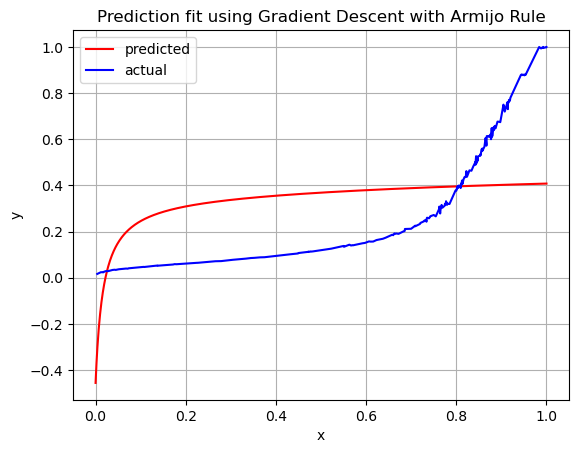

In [32]:
#TODO 24
# Extract the final weight vector from optimization history
w_mom = np.array(hist['w'])[999,:]
xp = np.linspace(0,1,num=1000)
# Use the final weight vector to make predictions
yhat = predict(w_mom,xp)
# Plot the predicted and actual values
plt.plot(xp,yhat, 'r')
plt.plot(x,y, 'b')
# Add labels
plt.xlabel( 'x')
plt.ylabel( 'y')
# Add a title,legend, grid
plt.gca().legend(('predicted','actual'))
plt.title('Prediction fit using Gradient Descent with Armijo Rule')
plt.grid() 